# 20.11. Multi-agent Environment 👾🤖👾

📍 [Download notebook](https://github.com/maxschmaltz/Course-LLM-based-Assistants/tree/main/llm-based-assistants/sessions/block2_core/2011/2011.ipynb)

In today'l lab, we will create a multi-agent environment for automated meeting scheduling and preparation. We will see how the coordinator agent will communicate with two auxiliary agents to check time availability and prepare an agenda for the meeting.

Our plan for today:

* [Creating an Agent](#agents)
* [Centralized Multi-agent System](#lama)
* [Human in The Loop](#human)

## Prerequisites

To start with the tutorial, complete the steps [Prerequisites](../../../../infos/llm_inference_guide/README.md#prerequisites), [Environment Setup](../../../../infos/llm_inference_guide/README.md#environment-setup), and [Getting API Key](../../../../infos/llm_inference_guide/README.md#getting-api-key) from the [LLM Inference Guide](../../../../infos/llm_inference_guide/README.md).

Today, we have more packages so we'll use the requirements file to install the dependencies:

In [ ]:
!curl -o requirements.txt https://raw.githubusercontent.com/maxschmaltz/Course-LLM-based-Assistants/main/llm-based-assistants/sessions/block2_core/2011/requirements.txt
!pip install -r requirements.txt

Then as always, we will initialize our LLM first. This time, we will be using [llama-3.1-405b-instruct](https://build.nvidia.com/meta/llama-3_1-405b-instruct) again because ir handles multiple tools better (remember that a newer mode doesn't necessarily means better model, at least for some tasks).

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.rate_limiters import InMemoryRateLimiter

In [ ]:
# read system variables
import os
import dotenv

dotenv.load_dotenv()    # that loads the .env file variables into os.environ

In [ ]:
# choose any model, catalogue is available under https://build.nvidia.com/models
MODEL_NAME = "meta/llama-3.1-405b-instruct"

# this rate limiter will ensure we do not exceed the rate limit
# of 40 RPM given by NVIDIA
rate_limiter = InMemoryRateLimiter(
    requests_per_second=1 / 6,  # 10 requests per minute to be sure
    check_every_n_seconds=5,  # wake up every 5 seconds to check whether allowed to make a request,
    max_bucket_size=1  # controls the maximum burst size
)

llm = ChatNVIDIA(
    model=MODEL_NAME,
    api_key=os.getenv("NVIDIA_API_KEY"), 
    temperature=0,   # ensure reproducibility,
    rate_limiter=rate_limiter  # bind the rate limiter
)

<h2 id="agents">1. Creating an Agent 👾</h2>

Recap: a raw (textual) LLM can only generate text, is limited to what's in its training data, and can only give you a single response. An agent overcomes this limitations by attaching tools, memory, and often access to external data sources to the LLM. This means agents can take actions, remember previous interactions, use APIs, and iteratively work through complex problems by deciding what to do next based on intermediate results.

LangGraph thinks about agents in a simple way: they are a construct out of three key components: the LLM itself, the tools, and the looping logic (Observe–Plan–Act workflow). This creates a cycle where the agent can:

* Think about the problem
* Decide which tool to use
* Use the tool and see the result
* Think about whether it's done or needs to do more
* Repeat until the task is complete

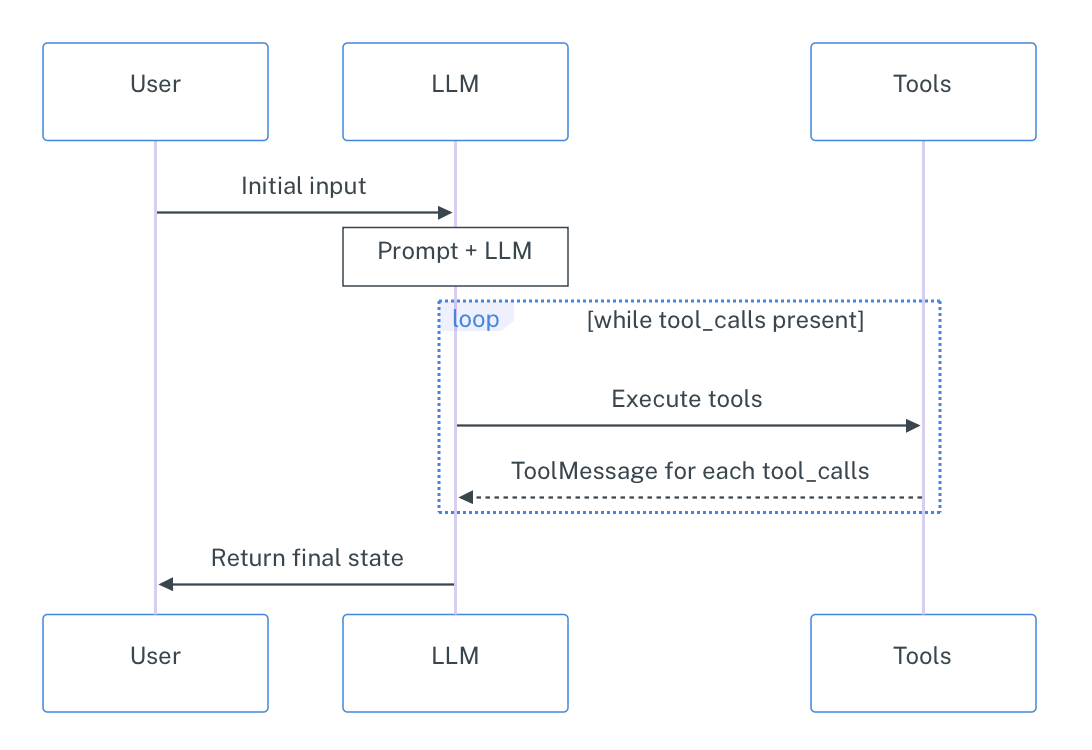

We will now create a very basic agent that can do simple math operations and calculate word length. This will help us understand the core concepts without getting too deep in complex functionality (yet).

We had initialized the LLM above, so now it's time for the tools. Remember that LangChain reads out the docstring and the type annotations to determine when to use this tool so don't forget to include those in your functions.

In [ ]:
from langchain_core.tools import tool

In [ ]:
@tool
def add_numbers(a: float, b: float) -> float:
    """Add two numbers together."""
    return a + b


@tool
def multiply_numbers(a: float, b: float) -> float:
    """Multiply two numbers together."""
    return a * b


@tool
def get_word_length(word: str) -> int:
    """Get the length of a word."""
    return len(word)


# put together
tools = [add_numbers, multiply_numbers, get_word_length]

To initialize the agent quickly, we use the [`create_react_agent`](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent) method from LangGraph; as mentioned before, it takes the LLM, the tools, and the couple of more parameters as the input and returns a fully functional graph with the Observe–Plan–Act workflow.

**IMPORTANT**: as of November 2025, the `create_react_agent` method is deprecated and moved to `langchain.agents.create_agent`. Conceptually these two are the same thing; there are a few technical differences but one can be converted into another easily. Since the principle framework for LLMs we use (`langchain_nvidia_ai_endpoints`) is not compatible with the latest LangGraph version, we stick to the older version. For more information about the new method see the [Agents tutorial](https://docs.langchain.com/oss/python/langchain/agents) from LangChain and [`create_agent` docu](https://reference.langchain.com/python/langchain/agents/).

In [ ]:
from langgraph.prebuilt import create_react_agent

In [ ]:
_basic_agent_prompt = """
Answer user questions using the provided tools. \
Always plan ahead first, then execute the plan step by step. \
If you face a complex task, break it down into smaller steps. \
You may use only one tool per action. \
Return only the results with no additional text.
"""

basic_agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt=_basic_agent_prompt
)

In [ ]:
from IPython.display import Image, display

In [ ]:
def draw_graph(agent, output_file_path: None):
    graph_image = agent.get_graph().draw_mermaid_png(
        output_file_path=output_file_path,
    )
    display(Image(graph_image))

In [ ]:
draw_graph(basic_agent, "basic_agent.png")

In [ ]:
# wrapper for pretty print
def run_agent(agent, query, recursion_limit=50):
    input = {
        "messages": [("user", query)]
    }
    shown_messages = []
    for event in agent.stream(
        input,
        # set max recursion limit to avoid infinite loops
        config={"recursion_limit": recursion_limit},
        stream_mode="values"
    ):
        if event["messages"]:
            for message in event["messages"]:
                if not message.id in shown_messages:
                    shown_messages.append(message.id)
                    message.pretty_print()
                    print("\n")

In [ ]:
run_agent(basic_agent, "I need to calculate (523 + 32) * 28 and get the length of the resulting number spelled out.")

Please note that this implementation will always try to call tools until the answer is reached, which may be inadequate for some applications.

In [ ]:
run_agent(basic_agent, "What is the 5th largest country?")

As you can see, the default `create_react_agent` implementation is not optimal as it always tries to call a tool. To address this issue, we will insert a so-called `pre_model_hook`: a function that is called before the LLM. This function is a usual LangGraph node that is just incorporated in the default implementation.

In our case, we will make the LLM first plan the next action explicitly and then generate itself a command for the next action.

In [ ]:
from langchain_core.tools import render_text_description
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [ ]:
tools_description = render_text_description(tools)

_plan_next_instruction = f"""
You are an agent who has access to the following tools:


{tools_description}


Your task is to define the best next action based on the previous messages \
and the tools available. You can either call one tool or \
return a text message to the user.

Return the next action you think is best to take as a textual description. \
Only return the single next action and not the whole plan.


Examples:

User: What is the weather now in Paris?
Assistant: Call the get_weather tool with argument "Paris".


User: When is the apocalypse happening?
Assistant: Generate the answer yourself and exit, no tool calls are needed here.
"""


_plan_next_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", _plan_next_instruction),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [ ]:
def plan_next(state):
    next_action = (_plan_next_prompt | llm).invoke(state)
    return {"messages": next_action}

In [ ]:
basic_plus_agent = create_react_agent(
    model=llm,
    tools=tools,
    pre_model_hook=plan_next
)

In [ ]:
draw_graph(basic_plus_agent, "basic_plus_agent.png")

In [ ]:
run_agent(basic_plus_agent, "I need to calculate (523 + 32) * 28 and get the length of the resulting number spelled out.")

In [ ]:
run_agent(basic_plus_agent, "What is the 5th largest country?")

<h2 id="lama">2. Centralized Multi-agent System 👾🤖👾</h2>

In this section, we'll create a multi-agent system for automated meeting scheduling and preparation. Our system will consist of three specialized agents:

* _Scheduler Agent_ - checks the availabilities of required participants and selects time slots that work for everyone
* _Creative Agent_ - reviews the project plan and generates a comprehensive agenda for the meeting
* _Coordinator Agent_ - orchestrates the other two agents, deciding when to call each one and combining their outputs

This will demonstrate how different agents can collaborate, each with their own expertise, to solve complex problems that would be difficult for a single agent to handle efficiently.

### Executor Agents

For this tutorial, we're focusing on understanding the multi-agent **workflow** and coordination patterns, so to avoid losing time for configuration of actual API integrations and external dependencies, we'll implement dummy functions that simulate real-world services. We will respectively create a dummy calendar function that will output random hourly time slots, and a dummy RAG function that will simulate the process of retrieving relevant information about the project for agenda preparation.

In [ ]:
import random

In [ ]:
@tool
def check_calendar_availability(name: str) -> list[str]:
    
    """
    Retrieving availability of the worker from their calendar.
    Returns a list of available time slots for a given person.
    
    Args:
        name: The person's name to check availability for
        
    Returns:
        List of available time slots as strings (e.g., ["14:00-15:00", "15:30-16:30"])
    """
    
    # generate all possible hourly slots from 10:00-11:00 to 17:00-18:00 (increments by 30 minutes)
    all_slots = []
    start_hour = 10
    end_hour = 17
    
    for hour in range(start_hour, end_hour):
        all_slots.append(f"{hour:02d}:00-{hour + 1:02d}:00")
        all_slots.append(f"{hour:02d}:30-{hour + 1:02d}:30")
    
    # randomly select 2-5 available slots for this person;
    # since this is a dummy random function,
    # we won't use the name since there's no real calendar to check,
    # but the agent doesn't know that
    num_available = random.randint(2, 5)
    available_slots = random.sample(all_slots, num_available)
    
    return sorted(available_slots)

In [ ]:
_project_state = """
Current Project: Mobile App Redesign (Q2 2024)

Status: In Progress (Week 6 of 12)

Recent Milestones:
- User research completed (Week 3)
- Wireframes approved by stakeholders (Week 5)
- Initial design mockups completed (Week 6)

Upcoming Milestones:
- Prototype development (Week 8-10)
- User testing sessions (Week 11)
- Final design handoff (Week 12)

Current Blockers:
- Waiting for brand guidelines update from marketing team
- Need approval on accessibility requirements

Budget Status: 70% utilized, on track
Timeline Status: Slightly behind schedule due to extended user research phase
"""


@tool
def retrieve_project_information(query: str) -> str:

    """
    Query the internal documents to retrieve relevant project information.
    
    Args:
        query: The information being requested about the project
        
    Returns:
        Project information as a string
    """
    
    return _project_state   # make it static

Now let's create our two executor agents, each with access to their respective tools:
* We'll bind the _Scheduler Agent_ with the dummy calendar function
* We'll bind the _Creative Agent_ with the dummy RAG function

For these two agents, we'll use the `create_react_agent` again.

In [ ]:
_scheduler_agent_prompt = """\
You are a scheduling assistant. Your job is to check participant availability \
and find time slots that work for everyone. You will be given the list of participants \
and your task is to find the shared available time slots for a meeting -- \
that is, time slots that are available for all participants. \
Only return the common slots as a list of strings \
(e.g., ["14:00-15:00", "15:30-16:30"]). \
If there are no common slots, say "No common slots available".
"""

scheduler_agent = create_react_agent(
    model=llm, 
    tools=[check_calendar_availability],
    prompt=_scheduler_agent_prompt,
    name="scheduler_agent"  # add names for the coordinator
)

In [ ]:
_creative_agent_prompt = """
You are a meeting preparation assistant. Your job is to create comprehensive meeting agendas \
based on current project status and goals. Always retrieve the latest project information first.
"""

creative_agent = create_react_agent(
    model=llm,
    tools=[retrieve_project_information], 
    prompt=_creative_agent_prompt,
    name="creative_agent"  # add names for the coordinator
)

### Coordinator Agent

A coordinator agent (also called a supervisor, or an orchestrator) is a special type of agent that doesn't perform tasks directly. Instead, it decides which other agents should work on different parts of a complex request. The coordinator analyzes incoming requests, breaks them down into subtasks, assigns those subtasks to the appropriate agents, and then combines the results into a final response.

A separate package [`langgraph-supervisor`](https://langchain-ai.github.io/langgraph/agents/multi-agent/#supervisor) allows us to create a coordinator agent from a template; the default implementation works the following way:
1. The coordinator gets the input from the user / the last executor
2. The coordinator decides which agent should step in next
3. The chosen executor gets the whole message history and generates the output
4. The output is returned to the coordinator, and the process loops

This implementation is not optimal because 1) there is no information segregation (all agents see the same messages); 2) the executors should decide themselves what exactly to do => no real coordination is going on. To address that, we'll customize the coordinator with a so-called _handoff function_ -- that is the function that defines what the output of the supervisor looks like. Namely, we'll have our coordinator generate specific textual commands for the executors, and limit the informational scope of the executors to those commands. So now the workflow will look like this:
1. The coordinator gets the input from the user / the last executor
2. The coordinator decides which agent should step in next
3. The coordinator generates a specific task for the next agent
4. The chosen executor gets only this command and generates the output
5. The output is returned to the coordinator, and the process loops

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.types import Command
from langgraph.prebuilt import InjectedState
from langgraph.types import Send
from typing import Annotated

In [ ]:
def create_task_description_handoff_tool(agent_name: str, description: str):

    name = f"transfer_to_{agent_name}"  # name of the tool

    @tool(name, description=description)
    def handoff_tool(
        # this will be populated by the coordinator;
        # the coordinator will see in the docstring that this
        # tool needs a task description to be passed so it 
        # will generate one as the required parameter
        task_description: str,
        # the `InjectedState` annotation will ensure that the
        # current state will be passed to the tool
        # and this parameter will be ignored by the LLM
        state: Annotated[dict, InjectedState],
    ) -> Command:
        
        """
        Delegate the task to another agent with a specific task description. The string \
        task description is required to specify what the target agent should do.

        Args:
            task_description: A detailed description of the task to be performed by the target agent.
        """
        
        # wrap the task description in an AI message (alternatively, you can use a user message)
        task_description_message = AIMessage(content=task_description)
        # this is a copy of the current state, but instead of the conversation history
        # it will contain the single task description message
        agent_input = {**state, "messages": [task_description_message]}
        
        # `Command` is an advanced graph navigation method;
        # it allows to execute a required action in the graph
        # immediately without the need to explicitly define
        # rooting logic for it; for example, instead of defining
        # a separate conditional node in the graph
        # that would check to which agent to transfer the task,
        # we can just use `Command` to send the task to the agent directly,
        # which also helps to keep the state cleaner
        return Command(
            # that is the action to perform;
            # `Send` is a special command that sends this specific input
            # to the specified agent -- it's like calling
            # `agent_name.invoke(agent_input)` but in the graph context;
            # the reason to do that is that otherwise the agent would
            # receive the shared state and not this specific "temporary" state
            goto=[Send(agent_name, agent_input)],
            # that says that the required agent is in the parent context
            # (so in the main graph) and not in the local context
            graph=Command.PARENT
        )

    return handoff_tool

In [ ]:
# init tools
assign_to_scheduler_agent_with_description = create_task_description_handoff_tool(
    agent_name="scheduler_agent",
    description="Assign task to the scheduler agent."
)

assign_to_creative_agent_with_description = create_task_description_handoff_tool(
    agent_name="creative_agent",
    description="Assign task to the creative agent."
)

Now we are ready to create our supervisor. The `create_supervisor` function will take care about all the routing, you should only give it the agents to manage and our custom handoff tools so that it generates the tasks explicitly.

In [ ]:
from langgraph_supervisor import create_supervisor

In [ ]:
_lama_prompt = """
You are the head of a team of agents, and your task is to set up meetings \
and prepare agendas for them. You have two agents at your disposal:
- **Scheduler Agent**: Responsible for checking participant availability and finding common time slots. \
If it will return you several available slots, pick one yourself.
- **Creative Agent**: Responsible for preparing meeting agendas based on the current project status.
Your task is to delegate tasks to these agents based on the user requests. \
When delegating the task, necessarily provide a detailed task description \
to the agent so it knows what to do. Do not stop until the task is completed.

Assign work to one agent at a step, do not call the agents in parallel. \
Do not do any work yourself.
"""

coordinator = create_supervisor(
    agents=[
        scheduler_agent,
        creative_agent
    ],
    tools=[
        assign_to_scheduler_agent_with_description,
        assign_to_creative_agent_with_description
    ],
    model=llm,
    prompt=_lama_prompt,
    supervisor_name="coordinator",
    output_mode="full_history",  # keep the full history of the conversation
    add_handoff_messages=True,  # add messages about task handoff to the conversation
    add_handoff_back_messages=True,  # add messages about task handoff back to the coordinator
    parallel_tool_calls=False
)

lama = coordinator.compile()

In [ ]:
draw_graph(lama, "lama.png")

In [ ]:
run_agent(lama, "Schedule a meeting with Jake, Mike, and Lucy to discuss the project status and prepare an agenda for it.", recursion_limit=100)

<h2 id="human">3. Human in The Loop 👾🤖🧐👾</h2>

Next thing we want to learn to do is adding human input **within** our pipeline. In multi-agent environments, involving a human can help handle ambiguous situations, resolve issues AI for some reason can't, or just approve/reject AI suggestion. By combining the strengths of both humans and AI agents, we can achieve more reliable and robust solutions.

In our pipeline, when the time slot is found and an agenda is prepared, we will ask for a human approval before finalizing the task. For that, we will just need to insert a special node for receiving human input (more below).

Actually, under the hood the `create_supervisor` function creates yet another ReACT agent, but instead of usual tools, it has the agent executors (well technically, it has tools to call them):
```python
# simplified but conceptually correct
coordinator = create_react_agent(
    model=llm,
    tools=[
        assign_to_scheduler_agent_with_description,
        assign_to_creative_agent_with_description
    ],
    prompt=_lama_prompt,    # reuse the prompt
    name="coordinator"
)
```

 Now, you remember that we added a so-called `pre_mode_hook` to our [basic agent](#agents) (also a ReACT agent) to handle the absence of explicit planning. It added a custom node before the agent was invoked. Now we'll do the opposite and add a `post_model_hook` to our coordinator which will be called after the agent generation. It will check if the coordinator decided to exit and will redirect the system to the human input node before exiting.

How will we know if the coordinator decided to exit? It's actually really easy: a default ReACT agent can either call tools, or exit with a ready response. So if the latest message (that is the one from the coordinator) does not contain tool calls, it means that the coordinator has decided to exit and its response is contained in the usual `.content` property. It is this response that we will be redirecting to the human for approval.

Creating a human-in-the loop functionality is fairly easy with LangGraph: you just need to stop the workflow with a special `interrupt()` function and then return a familiar to us `Command` to continue it from the point we point to. In our case, we will redirect the workflow back to the coordinator for it to decide which changes should be made based on the human feedback

When the `interrupt()` function is executed, it actually stops the pipeline until the human input is given and it works such that the whole node where this function was called is re-executed; that is why it is highly recommended to have a separate node that handles human input in order to not regenerate anything that has already been done.

In [ ]:
from langgraph.types import interrupt
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END

In [ ]:
def maybe_ask_human(state):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return {}   # just resume the graph execution
    ai_message = last_message.content
    # when interrupting the graph, we can also show some text
    # to the user; it the user prints "ok", it means that the user
    # approves the suggestion; this is a fairly simple way to
    # detect whether the user approves the suggestion or not,
    # we adopt it here for simplicity; we might have as well
    # used an LLM or a smaller LM-classifier
    response = interrupt(f"Here's my suggestion:\n\n{ai_message}\n\nWaiting for approval. Print 'ok' if it works for you.")
    if response.strip().lower() == "ok":
    # stop if the suggestion works
        return Command(
            goto=END,
            update={"messages": HumanMessage(content=response)}  # this will update the state
        )
    # redirect back to the coordinator with the human response otherwise
    return Command(
        # here we don't use the `Send` because we want the whole state to be passed
        goto="coordinator",
        update={"messages": HumanMessage(content=response)},  # this will update the state
        graph=Command.PARENT
    )

Since `interrupt()` stops the pipeline, LangGraph needs to remember where it left off to resume from there. To enable this, we use the `InMemorySaver` -- the same tool for checkpointing between the sessions we used in the [lab about basic chatbots](../0611.ipynb).

In [ ]:
coordinator_h = create_supervisor(
    agents=[
        scheduler_agent,
        creative_agent
    ],
    tools=[
        assign_to_scheduler_agent_with_description,
        assign_to_creative_agent_with_description
    ],
    model=llm,
    prompt=_lama_prompt,
    supervisor_name="coordinator",
    output_mode="full_history",  # keep the full history of the conversation
    add_handoff_messages=True,  # add messages about task handoff to the conversation
    add_handoff_back_messages=True,  # add messages about task handoff back to the coordinator
    parallel_tool_calls=False,
    post_model_hook=maybe_ask_human  # ask the human for confirmation
)

lama_h = coordinator_h.compile(checkpointer=InMemorySaver())    # checkpointer here

When you are streaming graph execution and it gets interrupted, it returns a special event with an `"__interrupt__"` key that contains the content we passed to the `interrupt()` function. 

To the best of my knowledge, the only way to detect an interruption automatically is to directly check for this key. In the wrapper function below, we check if there is an interrupt and prompt the user to answer the question if there is. The value under this key will contain a tuple with a single (in our case) `Interrupt` object with our text under the `.value` property.

After we received an answer from the human, we resume our workflow with a `Command`. It will throw us back to the node where the `interrupt()` function was called, and from there we will retrieve the answer and pass it back to the coordinator with yet another `Command`.

Here is the tricky part: since the interruption actually stops the pipeline, we should **run it anew** -- and that is why we need the checkpointer because it would have otherwise started from the very beginning. So to keep the pipeline even with the interruption running without our intervention, we wrap the launching into a loop; it will initially be run with the first request form the user, and then whenever an interruption is encountered, we will update the input to whatever the user has answered and the loop will rerun this pipeline with this new updated input.

In [ ]:
# wrapper for pretty print
def run_agent_with_checkpoint(agent, query, recursion_limit=50):
    # initial input
    pipeline_input = {
        "messages": [("user", query)]
    }
    shown_messages = []
    while True: # this is needed to handle user interruptions
        for event in agent.stream(
            pipeline_input,
            config={
                "configurable": {
                    "thread_id": "1"
                },  
                "recursion_limit": recursion_limit
            },
            stream_mode="values"
        ):
            if "__interrupt__" in event:
                question = event["__interrupt__"][0].value  # retrieve the question
                answer = input(question)    # get the answer from the user
                pipeline_input = Command(resume=answer) # update the input with the answer
                print("================================== Interruption ==================================")
                print(question)
            if "messages" in event:
                if isinstance(event["messages"][-1], HumanMessage) and event["messages"][-1].content == "ok":
                    return  # interrupt the execution if the user approves the suggestion
                for message in event["messages"]:
                    if not message.id in shown_messages:
                        shown_messages.append(message.id)
                        message.pretty_print()
                        print("\n")

In [ ]:
run_agent_with_checkpoint(lama_h, "Schedule a meeting for Jake and Mike to discuss the project status and prepare an agenda for it.", recursion_limit=100)